In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [76]:
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
images = np.genfromtxt('data/mnist_train.csv', delimiter=',')

In [4]:
images.shape

(6000, 785)

In [5]:
np.unique(images[:, 0])

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [6]:
image_X, image_y = images[:, 1:], images[:, 0]

image_X.shape, image_y.shape

((6000, 784), (6000,))

In [7]:
np.max(image_X), np.min(image_X)

(255.0, 0.0)

Text(0.5,1,'label: 5')

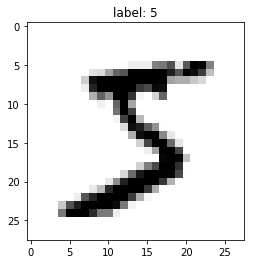

In [8]:
plt.imshow(image_X[0].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title('label: {:.0f}'.format(image_y[0]))

#### Preprocessing data

In [37]:
# scale [0, 1]
image_X /= 255.

# binary pixels
image_X = np.where(image_X > .5, 1.0, 0.0)

Text(0.5,1,'label: 5')

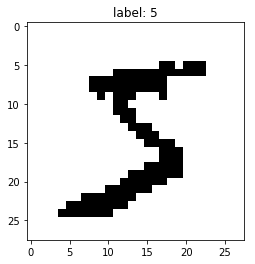

In [32]:
plt.imshow(image_X[0].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title('label: {:.0f}'.format(image_y[0]))

In [38]:
image_X.max(), image_X.min()

(1.0, 0.0)

#### extracting components using PCA

In [10]:
# pca 
pca = PCA(n_components=100)
X_pca = pca.fit_transform(image_X)

X_pca.shape

(6000, 100)

Text(0,0.5,'cumulative variance ratio')

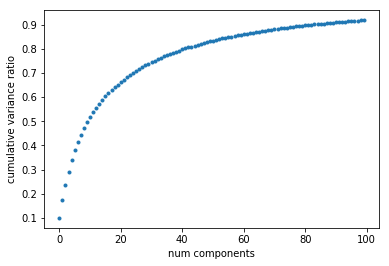

In [26]:
plt.plot(pca.explained_variance_ratio_.cumsum(), '.')
plt.xlabel('num components')
plt.ylabel('cumulative variance ratio')

In [15]:
pca.components_.shape

(100, 784)

In [71]:
def plot_component(row_components, rows=10, cols=10):
    im = np.zeros(shape=(rows*28, cols*28))
    for i, component in enumerate(row_components):
        r, c = i//cols, i%cols
        im[r*28:(r+1)*28, c*28:(c+1)*28] = component.reshape(28, 28)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(im, cmap=plt.cm.gray_r)

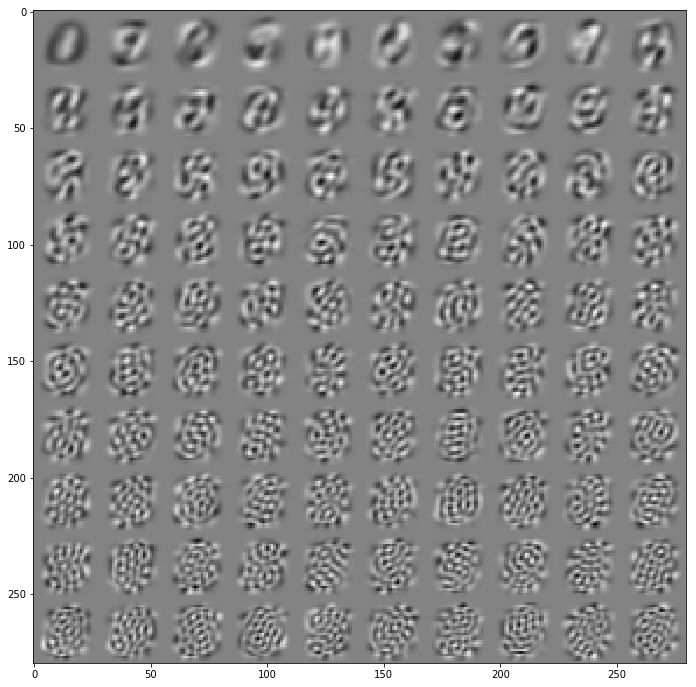

In [49]:
plot_component(pca.components_, 10, 10)

In [31]:
np.allclose(pca.transform(image_X[:1]), 
            np.dot(image_X[0] - image_X.mean(axis=0), pca.components_.T))

True

#### Extracting components using RBM

In [39]:
rbm = BernoulliRBM(random_state=0, n_iter=20, verbose=True, n_components=100)

In [40]:
rbm.fit(image_X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -138.59, time = 1.26s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -120.25, time = 1.54s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -116.46, time = 1.57s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -127.44, time = 1.59s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -115.50, time = 1.47s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -116.76, time = 1.40s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -117.61, time = 1.37s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -121.79, time = 1.45s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -114.84, time = 1.42s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -112.97, time = 1.39s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -105.80, time = 1.42s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -109.35, time = 1.44s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -107.76, time = 1.40s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -105.23, time = 1.45s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=20,
       random_state=0, verbose=True)

In [42]:
rbm.components_.shape

(100, 784)

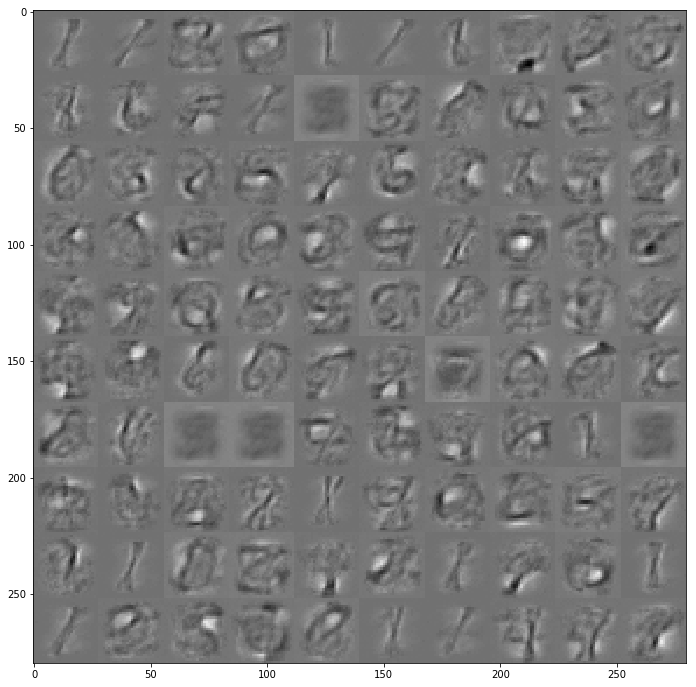

In [50]:
plot_component(rbm.components_, 10, 10)

In [65]:
X_rbm = rbm.transform(image_X)
X_rbm.shape

(6000, 100)

In [66]:
np.allclose(X_rbm[:1], 
            np.dot(image_X[0]-image_X.mean(axis=0), rbm.components_.T))

False

In [67]:
top20_features_first_image = np.argsort(X_rbm[0])[-20:][::-1]
top20_features_first_image

array([14, 62, 63, 69, 56, 29, 34, 28, 92, 82, 45, 49, 83, 58, 41, 21, 15,
       44, 18, 77], dtype=int64)

In [73]:
image_y[0]

5.0

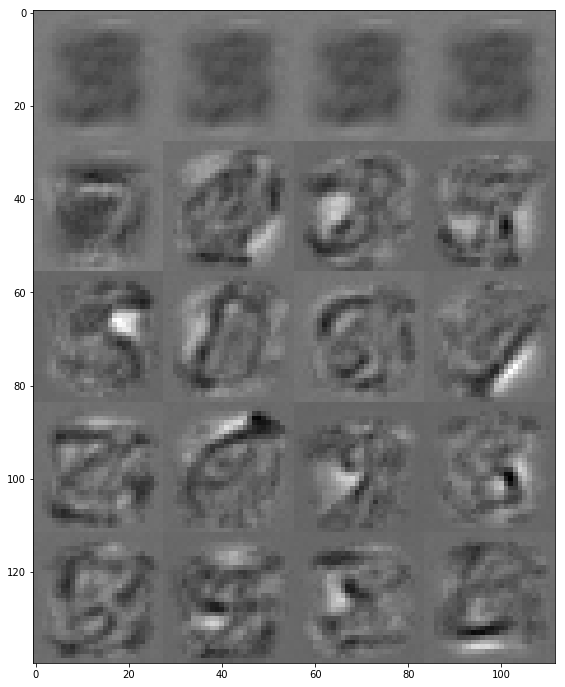

In [72]:
plot_component(rbm.components_[top20_features_first_image], 5, 4)

In [74]:
bottom20_features_first_image = np.argsort(X_rbm[0])[:20]
bottom20_features_first_image

array([12, 88, 51,  4, 84, 97, 50, 91, 98, 54, 16, 89, 86, 35, 99, 87, 24,
        1, 25, 40], dtype=int64)

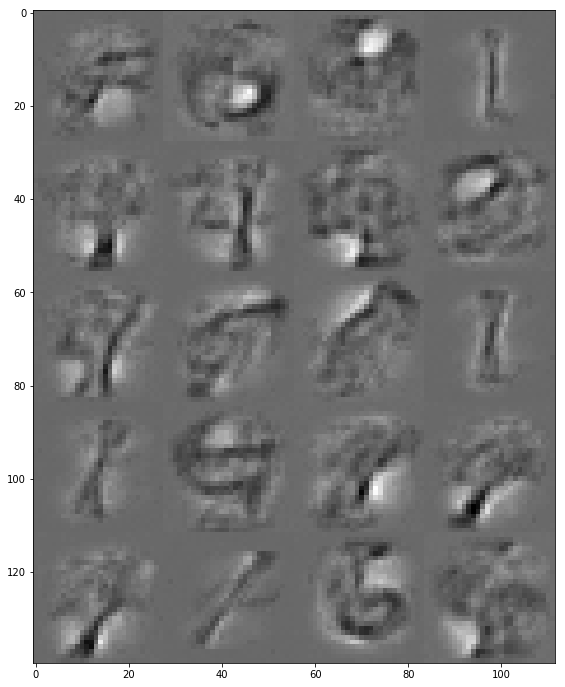

In [75]:
plot_component(rbm.components_[bottom20_features_first_image], 5, 4)

#### Using RBMs in a machine learning pipeline

In [77]:
# baseline -> raw pixels + LogisticRegression
raw_params = {'C': [.01, .1, 1, 10, 100]}
raw_grid = GridSearchCV(LogisticRegression(), raw_params)
raw_grid.fit(image_X, image_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [78]:
raw_grid.best_score_, raw_grid.best_params_

(0.8908333333333334, {'C': 0.1})

In [84]:
# Pipe 1 -> PCA + LogisticRegression
pca_pipe = Pipeline([
    ('pca', PCA()),
    ('clf', LogisticRegression()),
])

pca_params = {
    'pca__n_components': [10, 100, 200],
    'clf__C': [.01, .1, 1, 10, 100],
}

pca_grid = GridSearchCV(pca_pipe, pca_params)
pca_grid.fit(image_X, image_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.01, 0.1, 1, 10, 100], 'pca__n_components': [10, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
pca_grid.best_score_, pca_grid.best_params_

(0.8885, {'clf__C': 10, 'pca__n_components': 100})

In [86]:
# Pipe 2 -> RBM + LogisticRegression
rmb_pipe = Pipeline([
    ('rbm', BernoulliRBM(random_state=0)),
    ('clf', LogisticRegression()),
])

rmb_params = {
    'rbm__n_components': [50, 100, 150],
    'clf__C': [.1, 1, 10],
}

rmb_grid = GridSearchCV(rmb_pipe, rmb_params)

rmb_grid.fit(image_X, image_y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=256, n_iter=10,
       random_state=0, verbose=0)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 1, 10], 'rbm__n_components': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
rmb_grid.best_score_, rmb_grid.best_params_

(0.9071666666666667, {'clf__C': 1, 'rbm__n_components': 150})

#### Learning text features -- word vectorizations

In [88]:
import logging
import gensim
from gensim.models import word2vec, Word2Vec

In [89]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [93]:
corpus = word2vec.Text8Corpus('./data/text8')

In [94]:
model = Word2Vec(sentences=corpus, min_count=1, size=20)

2018-06-23 13:44:28,688 : INFO : collecting all words and their counts
2018-06-23 13:44:28,717 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-06-23 13:44:39,016 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2018-06-23 13:44:39,017 : INFO : Loading a fresh vocabulary
2018-06-23 13:44:40,641 : INFO : min_count=1 retains 253854 unique words (100% of original 253854, drops 0)
2018-06-23 13:44:40,642 : INFO : min_count=1 leaves 17005207 word corpus (100% of original 17005207, drops 0)
2018-06-23 13:44:42,308 : INFO : deleting the raw counts dictionary of 253854 items
2018-06-23 13:44:42,325 : INFO : sample=0.001 downsamples 36 most-common words
2018-06-23 13:44:42,326 : INFO : downsampling leaves estimated 12819131 word corpus (75.4% of prior 17005207)
2018-06-23 13:44:43,813 : INFO : estimated required memory for 253854 words and 20 dimensions: 167543640 bytes
2018-06-23 13:44:43,815 : INFO : resetting layer wei

2018-06-23 13:45:48,602 : INFO : EPOCH 3 - PROGRESS: at 69.84% examples, 593223 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:49,603 : INFO : EPOCH 3 - PROGRESS: at 75.13% examples, 598333 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:50,611 : INFO : EPOCH 3 - PROGRESS: at 79.95% examples, 598369 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:51,617 : INFO : EPOCH 3 - PROGRESS: at 84.83% examples, 599654 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:52,630 : INFO : EPOCH 3 - PROGRESS: at 89.54% examples, 599555 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:53,641 : INFO : EPOCH 3 - PROGRESS: at 94.12% examples, 598399 words/s, in_qsize 5, out_qsize 1
2018-06-23 13:45:54,646 : INFO : EPOCH 3 - PROGRESS: at 98.53% examples, 596517 words/s, in_qsize 5, out_qsize 0
2018-06-23 13:45:54,922 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-06-23 13:45:54,930 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-06-23 13:45:54,941 : I

In [95]:
model.wv['king']

array([-2.1769633 , -0.20803618,  1.8193969 , -0.68177456, -8.3979    ,
        0.5947793 , -0.71206206,  2.0340965 , -0.21741253,  6.11663   ,
       -0.30774415,  1.9807729 ,  2.0768223 , -6.440095  ,  0.7106696 ,
       -1.1936996 , -0.3203001 , -2.8982697 ,  1.1799812 ,  2.6824064 ],
      dtype=float32)

In [96]:
model.wv.most_similar(positive=['king', 'woman'], negative=['man'])

2018-06-23 13:52:23,421 : INFO : precomputing L2-norms of word weight vectors


[('empress', 0.8949152231216431),
 ('emperor', 0.8841361999511719),
 ('prince', 0.8733543157577515),
 ('consul', 0.8679289817810059),
 ('son', 0.8630583882331848),
 ('elector', 0.858869731426239),
 ('sons', 0.8577502369880676),
 ('viii', 0.8440794348716736),
 ('tsar', 0.8423082828521729),
 ('emperors', 0.8421576619148254)]

In [98]:
len(model.wv.vocab)

253854

In [100]:
# pre-trained embeddings

model = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/LENOVO/Downloads/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

2018-06-23 14:01:25,231 : INFO : loading projection weights from C:/Users/LENOVO/Downloads/GoogleNews-vectors-negative300.bin
2018-06-23 14:03:12,652 : INFO : loaded (3000000, 300) matrix from C:/Users/LENOVO/Downloads/GoogleNews-vectors-negative300.bin


In [102]:
len(model.vocab)

3000000

In [104]:
model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

[('queen', 0.7118192911148071)]

In [106]:
model.most_similar(positive=['England', 'Paris'], negative=['London'], topn=1)

[('France', 0.667637825012207)]

In [125]:
model.most_similar(positive=['woman', 'married'], negative=['man'], topn=3)

[('divorced', 0.7308854460716248),
 ('remarried', 0.677160382270813),
 ('marry', 0.6742445230484009)]

In [129]:
model.most_similar(positive=['water', 'hungry'], negative=['food'], topn=3)

[('thirsty', 0.5537034273147583),
 ('thirsting', 0.4457513093948364),
 ('Water', 0.43411606550216675)]

In [116]:
model.doesnt_match(words='duck bear cat tree'.split())

'tree'

In [119]:
model.doesnt_match(words='car pedestrian road tree'.split())

'tree'

In [122]:
model.similarity('man', 'woman'), model.similarity('man', 'dog')

(0.7664012230995352, 0.30886472579067986)

In [123]:
model.similarity('dog', 'tree'), model.similarity('man', 'tree')

(0.2898024042569019, 0.22937458713940162)

In [141]:
def get_embedding(word):
    try:
        return model[word]
    except KeyError:
        return None

In [148]:
def sentence_mean_vec(sentence):
    return np.mean([get_embedding(word) for word in sentence.split() 
                    if get_embedding(word) is not None], axis=0)

In [142]:
sentences = [
    'this is about a dog',
    'this is about a cat',
    'this in about nothing',
]

In [149]:
vectorized_sentences = np.zeros(shape=(len(sentences), 300))

for i, sentence in enumerate(sentences):
    vectorized_sentences[i, :] = sentence_mean_vec(sentence)

In [151]:
vectorized_sentences.shape

(3, 300)

In [165]:
def get_best_title(query_word):
    best_match = np.dot(vectorized_sentences, get_embedding(query_word)).argsort()[-1]
    best_title = sentences[best_match]
    print(best_title)

In [155]:
get_best_title('dog')

this is about a dog


In [156]:
get_best_title('cat')

this is about a cat


In [157]:
get_best_title('canine')

this is about a dog


In [158]:
get_best_title('tiger')

this is about a cat


In [159]:
sentences = """How to Sound Like a Data Scientist
Types of Data
The Five Steps of Data Science 
Basic Mathematics
A Gentle Introduction to Probability
Advanced Probability 
Basic Statistics
Advanced Statistics
Communicating Data 
Machine Learning Essentials
Beyond the Essentials
Case Studies """.split('\n')

In [160]:
len(sentences)

12

In [162]:
vectorized_sentences = np.zeros(shape=(len(sentences), 300))

for i, sentence in enumerate(sentences):
    vectorized_sentences[i, :] = sentence_mean_vec(sentence)
vectorized_sentences.shape

(12, 300)

In [166]:
get_best_title('math')

Basic Mathematics


In [167]:
get_best_title('talk')

Communicating Data 


In [168]:
get_best_title('AI')

Advanced Probability 
